In [ ]:
# %pip install antspyx nilearn

In [ ]:
#Run this once
%load_ext autoreload
%autoreload 2
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
project_dir = "/codespace/braintypicality"
sys.path.append(project_dir)

In [3]:
import re
import functools
import glob
import math
import ants
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from functools import partial
from nilearn import datasets, plotting
import os 

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# #####
CACHE_DIR = "/ASD/ahsan_projects/braintypicality/dataset/template_cache/"

procd_ref_img_path = f"{CACHE_DIR}/cropped_niral_mni.nii.gz"

# if not os.path.exists(procd_ref_img_path):
T1_REF_IMG_PATH = os.path.join(
    CACHE_DIR, "mni_icbm152_09a/mni_icbm152_t1_tal_nlin_sym_09a.nrrd"
)
T2_REF_IMG_PATH = os.path.join(
    CACHE_DIR, "mni_icbm152_09a/mni_icbm152_t2_tal_nlin_sym_09a.nrrd"
)
MASK_REF_IMG_PATH = os.path.join(
    CACHE_DIR, "mni_icbm152_09a/mni_icbm152_t1_tal_nlin_sym_09a_mask.nrrd"
)

ants_mni = ants.image_read(f"{CACHE_DIR}/croppedMni152.nii.gz")
t1_ref_img = ants.image_read(T1_REF_IMG_PATH)
t2_ref_img = ants.image_read(T2_REF_IMG_PATH)
ref_img_mask = ants.image_read(MASK_REF_IMG_PATH)

# Use ANTs' tighter cropping
diff = np.array(t1_ref_img.shape) - np.array(ants_mni.shape)
crop_idxs_start, crop_idxs_end = 1 + diff // 2, np.array(t1_ref_img.shape) - diff // 2

t1_ref_img = ants.crop_indices(t1_ref_img, crop_idxs_start, crop_idxs_end)
t2_ref_img = ants.crop_indices(t2_ref_img, crop_idxs_start, crop_idxs_end)
ref_img_mask = ants.crop_indices(ref_img_mask, crop_idxs_start, crop_idxs_end)

procd_ref_img = ants.merge_channels((t1_ref_img * ref_img_mask, t2_ref_img * ref_img_mask))
procd_ref_img.to_filename(procd_ref_img_path)

In [5]:
from sade.configs.flows import ve_flow_config as configs
config = configs.get_config()

transforms_dir = f"/DATA/Users/amahmood/braintyp/spacing_{int(config.data.spacing_pix_dim)}"

def register_to_mni(x:np.ndarray, fname: str, multichannel=False):
    fname =  os.path.basename(fname)
    sampleid = re.match(r"(.*)(\.npz|\.nii.gz)", fname).group(1)
    transform_mat = f"{transforms_dir}/{sampleid}Composite.h5"
    
    if multichannel:
        x = x.transpose(1,2,3,0)
        x = ants.from_numpy(x)

        return ants.apply_transforms(
            fixed=ref_img_post_transform, interpolator="linear", verbose=False,
            moving=x, transformlist=transform_mat, imagetype = 3
        ).numpy().transpose(3,0,1,2)
        
    x = ants.from_numpy(x)
    return ants.apply_transforms(
        fixed=ref_img_post_transform, interpolator="linear", verbose=False,
        moving=x, transformlist=transform_mat
    )

In [6]:
from sade.configs.flows import ve_flow_config as configs
from sade.datasets.loaders import get_image_files_list, get_val_transform, get_lesion_transform
from sade.metrics import erode_brain_masks

workdir = "/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable"
unscale = lambda x: (x+1)/2

img_loader = get_val_transform(config)
img_and_label_loader = get_lesion_transform(config)

procd_ref_img_path = f"{CACHE_DIR}/cropped_niral_mni.nii.gz"
ref_img_tensor = img_loader({"image": procd_ref_img_path})["image"].numpy()
ref_img_post_transform = unscale(ants.from_numpy(ref_img_tensor[0]))

# ref_img_post_transform.to_filename('ps2-niral-mni-postproc.nii.gz')|

2025-01-14 20:58:19.378978: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-14 20:58:19.389234: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-14 20:58:19.402253: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-14 20:58:19.406170: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-14 20:58:19.415595: I tensorflow/core/platform/cpu_feature_guar

In [7]:
bmask = (ref_img_post_transform.numpy() > 0).astype(float)
BRAIN_MASK = ants.from_numpy(bmask)
# ERODED_BRAIN_MASK = ants.from_numpy(erode_brain_masks(BRAIN_MASK[None,...].numpy(),radius=2)[0])

In [8]:
workdir = "/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable/experiments/default-ckpt-150/"
dataset = "ibis-asd"
fnames = glob.glob(f"{workdir}/{dataset}/*")
fnames[0]

'/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable/experiments/default-ckpt-150//ibis-asd/IBIS107524.npz'

In [9]:
%mkdir $workdir/registered-heatmaps

mkdir: cannot create directory ‘/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable/experiments/default-ckpt-150//registered-heatmaps’: File exists


In [10]:
for f in tqdm(fnames):
    sid = re.match(r".*\/(.*)(\.npz|\.nii.gz)", f).group(1)
#     sid = sid.split("/")[0]
    data = np.load(f)
    x = data['heatmap']
    regx = register_to_mni(x, f)
    regx = regx * BRAIN_MASK
    regx.to_filename(f"{workdir}/registered-heatmaps/{sid}.nii.gz")

100%|██████████| 65/65 [00:23<00:00,  2.74it/s]


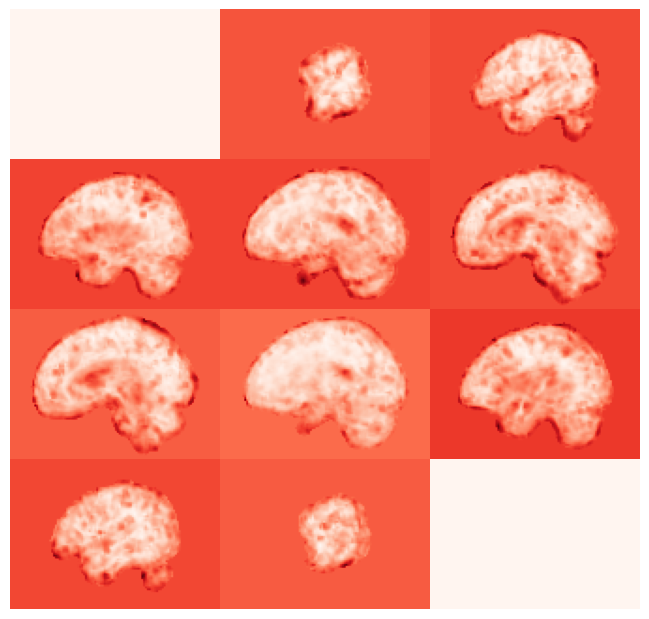

In [17]:
ants.plot(regx+10, cmap='Reds')

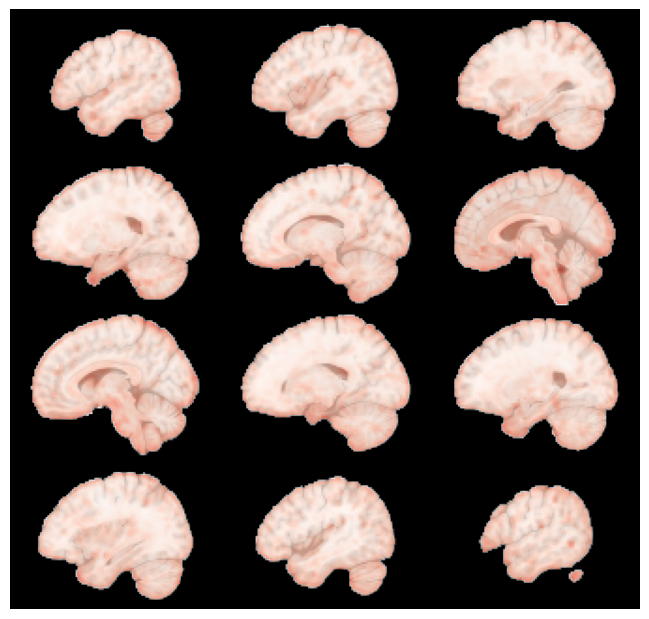

In [12]:
ants.plot(ref_img_post_transform, overlay=regx, overlay_cmap='Reds', overlay_alpha=0.6)

### Load AAL Atlas

In [13]:
aal_lobes = pd.read_csv('/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable/eval/heatmaps_v2/aal_labels_lobe.csv')
aal_lobes_to_index = aal_lobes.groupby('Lobe')['ROI-Index']
aal_lobes['Lobe'].nunique()

17

/home/amahmood/.local/lib/python3.10/site-packages/nilearn/datasets/atlas.py:1307: DeprecationWarning: Starting in version 0.13, the default fetched mask will beAAL 3v2 instead.
  warnings.warn(message, DeprecationWarning)


[get_dataset_dir] Dataset found in /ASD/ahsan_projects/braintypicality/dataset/template_cache/atlases/aal_SPM12

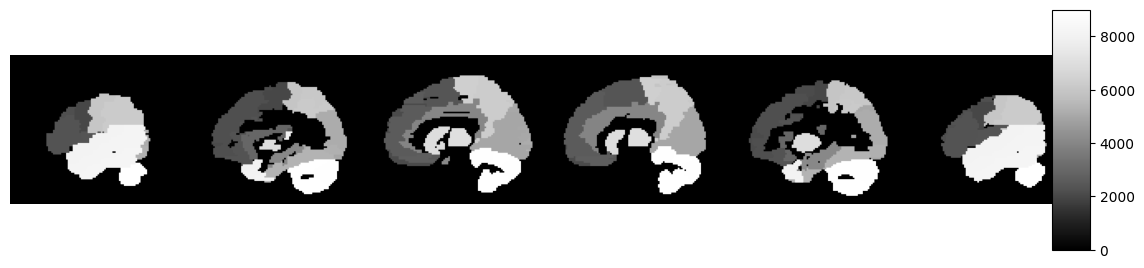

In [14]:
aal = datasets.fetch_atlas_aal(version='SPM12', data_dir=os.path.join(CACHE_DIR,"atlases"))
aal_img = ants.image_read(aal.maps, pixeltype='unsigned int')
aal_img.set_spacing((1.0,1.0,1.0))
aal_img.plot(nslices=6, cbar=True)

In [15]:
reg_dict = ants.registration(fixed=ref_img_post_transform, moving=aal_img,
                             type_of_transform = 'SyN', interpolator="nearest")
aal_transformed = ants.apply_transforms(
        fixed=ref_img_post_transform, moving=aal_img,
        transformlist=reg_dict["fwdtransforms"], interpolator="multiLabel",
    verbose=True
)
aal_transformed

['-d', '3', '-i', '0x7fe415eda228', '-o', '0x7fe415ed9388', '-r', '0x7fe4161ab0a8', '-n', 'multiLabel', '-t', '/tmp/tmpieym47gj1Warp.nii.gz', '-t', '/tmp/tmpieym47gj0GenericAffine.mat']
Using double precision for computations.
Input scalar image: 0x7fe415eda228
Could not create ImageIO for the input file, assuming dimension = 3 and scalar pixel type
Reference image: 0x7fe4161ab0a8
The composite transform comprises the following transforms (in order): 
  1. /tmp/tmpieym47gj0GenericAffine.mat (type = AffineTransform)
  2. /tmp/tmpieym47gj1Warp.nii.gz (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LabelImageGaussianInterpolateImageFunction
Output warped image: 0x7fe415ed9388


ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (96, 112, 80)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

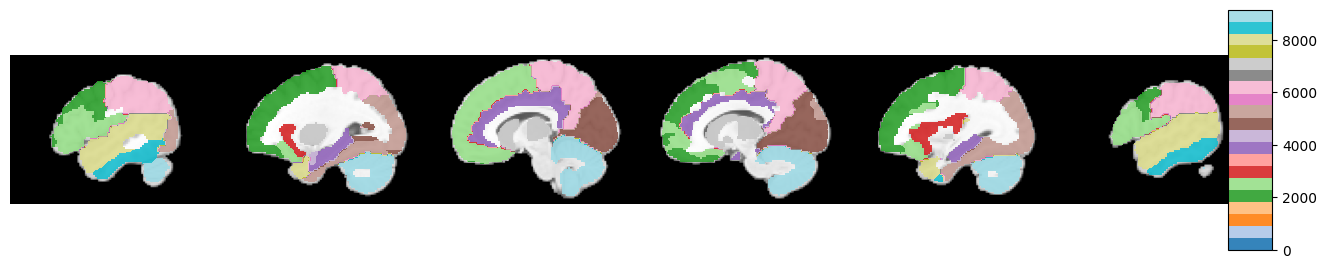

In [16]:
ref_img_post_transform.plot(overlay=aal_transformed, nslices=6, cbar=True, overlay_cmap="tab20")